In [1]:
import re

import numpy as np
import optuna as opt
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, ADASYN
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier

In [2]:
random_id = 17 #ai23m017 - 17 is the id
random_state = np.random.RandomState(random_id)

In [3]:
to_test = pd.read_csv("test.csv", index_col="PassengerId")
df = pd.read_csv("train.csv", index_col="PassengerId")
df

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
df = df.convert_dtypes()
df["Embarked"] = df["Embarked"].astype("category")
df.dtypes

Survived             Int64
Pclass               Int64
Name        string[python]
Age                Float64
SibSp                Int64
Parch                Int64
Ticket      string[python]
Fare               Float64
Cabin       string[python]
Embarked          category
dtype: object

In [5]:
X_train,X_test,y_train,y_test = train_test_split(df.drop("Survived", axis=1), df["Survived"], test_size=0.2, random_state=random_id)# stratify=df["Survived"])
print(df.columns[df.isna().any(axis=0)].tolist())

['Age', 'Cabin', 'Embarked']


In [6]:
#ros = RandomOverSampler(random_state=random_id)

In [7]:
X_train

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
874,3,"Vander Cruyssen, Mr. Victor",47.0,0,0,345765,9.0,<NA>,S
829,3,"McCormack, Mr. Thomas Joseph",<NA>,0,0,367228,7.75,<NA>,Q
100,2,"Kantor, Mr. Sinai",34.0,1,0,244367,26.0,<NA>,S
524,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",44.0,0,1,111361,57.9792,B18,C
133,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",47.0,1,0,A/5. 3337,14.5,<NA>,S
...,...,...,...,...,...,...,...,...,...
407,3,"Widegren, Mr. Carl/Charles Peter",51.0,0,0,347064,7.75,<NA>,S
391,1,"Carter, Mr. William Ernest",36.0,1,2,113760,120.0,B96 B98,S
144,3,"Burke, Mr. Jeremiah",19.0,0,0,365222,6.75,<NA>,Q


### Data Pre-Processing after splitting the data to prevent data - leakage

##### Data Imputation for the Age column by utilizing the mean of other values

In [8]:
#Data Imputation for the Age column
data = [X_train, X_test, to_test]
for dataset in data:
    mean = X_train["Age"].mean()
    std = X_test["Age"].std()
    is_null = dataset["Age"].isna().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    rand_age_series = pd.Series(rand_age, index=dataset[dataset["Age"].isnull()].index)
    dataset["Age"].fillna(rand_age_series, inplace=True)
    dataset["Age"] = dataset["Age"].astype(int)
    

##### Feature Engineering

In [9]:
#Feature Engineering the Deck Column 
#Cabins are mapped to a numerical Deck feature

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in data:
    
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
    dataset["Family_Name"] = dataset['Name'].str.split(',', n = 1, expand=True)[0]
    #dataset.drop(["Cabin"], axis=1, inplace=True)

In [10]:
X_train["Embarked"].describe()
for dataset in [X_train, X_test, to_test]:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)


In [11]:
X_train.isna().any()

Pclass         False
Name           False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
Deck           False
Family_Name    False
dtype: bool

In [12]:
#Feature Engineering Title Column
status_map={'Capt':'Military',
            'Col':'Military',
            'Don':'Noble',
            'Dona':'Noble',
            'Dr':'Dr',
            'Jonkheer':'Noble',
            'Lady':'Noble',
            'Major':'Military',
            'Master':'Common',
            'Miss':'Common',
            'Mlle':'Common',
            'Mme':'Common',
            'Mr':'Common',
            'Mrs':'Common',
            'Ms':'Common',
            'Rev':'Clergy',
            'Sir':'Noble',
            'the Countess':'Noble',
            }

for dataset in data:
    dataset["Title"] = dataset["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
    print(pd.unique(X_train["Title"]))
    #dataset['Social_Status'] = dataset['Title'].map(status_map)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


['Mr' 'Mrs' 'Miss' 'Master' 'Dr' 'Col' 'Rev' 'Jonkheer' 'Mlle' 'Sir' 'Ms'
 'Capt' 'Major' 'Don']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


In [13]:
#Feature Engineering Sex Column 
def map_to_sex(value):
    if value in ["Miss","Mrs"]:
        return "female"
    else:
        return "male"

for dataset in data:
    dataset["Sex"] = dataset["Title"].apply(map_to_sex)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    #dataset.drop("Title", axis=1, inplace=True)

In [14]:
X_train

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Family_Name,Title,Sex
PassengerId,,,,,,,,,,,,,
874,3,"Vander Cruyssen, Mr. Victor",47,0,0,345765,9.0,U0,S,8,Vander Cruyssen,Mr,0
829,3,"McCormack, Mr. Thomas Joseph",27,0,0,367228,7.75,U0,Q,8,McCormack,Mr,0
100,2,"Kantor, Mr. Sinai",34,1,0,244367,26.0,U0,S,8,Kantor,Mr,0
524,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",44,0,1,111361,57.9792,B18,C,2,Hippach,Mrs,1
133,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",47,1,0,A/5. 3337,14.5,U0,S,8,Robins,Mrs,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,3,"Widegren, Mr. Carl/Charles Peter",51,0,0,347064,7.75,U0,S,8,Widegren,Mr,0
391,1,"Carter, Mr. William Ernest",36,1,2,113760,120.0,B96 B98,S,2,Carter,Mr,0
144,3,"Burke, Mr. Jeremiah",19,0,0,365222,6.75,U0,Q,8,Burke,Mr,0


In [15]:
#Feature Engineering Family Size Column
for dataset in data:
    dataset["Fam_size"] = dataset["SibSp"] + dataset["Parch"] + 1
    #dataset["Fam_type"] = pd.cut(dataset.Fam_size, [0,1,4,7,11], labels=["Solo", "Small", "Big", "Very big"])
    dataset['IsAlone'] = 0
    dataset.loc[dataset['Fam_size'] == 1, 'IsAlone'] = 1
    dataset.drop(["SibSp","Parch"], axis=1, inplace=True)

In [16]:
X_train["Ticket"].duplicated().sum()


145

In [17]:
len(X_train)

712

In [18]:
X_train

,Pclass,Name,Age,Ticket,Fare,Cabin,Embarked,Deck,Family_Name,Title,Sex,Fam_size,IsAlone
PassengerId,,,,,,,,,,,,,
874,3,"Vander Cruyssen, Mr. Victor",47,345765,9.0,U0,S,8,Vander Cruyssen,Mr,0,1,1
829,3,"McCormack, Mr. Thomas Joseph",27,367228,7.75,U0,Q,8,McCormack,Mr,0,1,1
100,2,"Kantor, Mr. Sinai",34,244367,26.0,U0,S,8,Kantor,Mr,0,2,0
524,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",44,111361,57.9792,B18,C,2,Hippach,Mrs,1,2,0
133,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",47,A/5. 3337,14.5,U0,S,8,Robins,Mrs,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,3,"Widegren, Mr. Carl/Charles Peter",51,347064,7.75,U0,S,8,Widegren,Mr,0,1,1
391,1,"Carter, Mr. William Ernest",36,113760,120.0,B96 B98,S,2,Carter,Mr,0,4,0
144,3,"Burke, Mr. Jeremiah",19,365222,6.75,U0,Q,8,Burke,Mr,0,1,1


In [19]:
'''
for dataset in data:
    for i, row in dataset.iterrows():
        group_survival_estimate = 0.5
        
        # Identifiable family aboard
        if row['SibSp'] > 0 or row['Parch'] > 0:
            similar_passengers = dataset[
                (dataset['Pclass'] == row['Pclass']) &
                (dataset['Embarked'] == row['Embarked']) &
                (dataset['Fam_size'] == row['Fam_size']) &
                (dataset.index != i)
            ]
            
            
            if not similar_passengers.empty:
                survived_count = similar_passengers['Survived'].sum()
                total_count = similar_passengers['Survived'].count()
                group_survival_estimate = survived_count / total_count if total_count > 0 else 0.5
        
        
        dataset.at[i, 'GroupSurvivabilityEstimate'] = group_survival_estimate
'''

"\nfor dataset in data:\n    for i, row in dataset.iterrows():\n        group_survival_estimate = 0.5\n        \n        # Identifiable family aboard\n        if row['SibSp'] > 0 or row['Parch'] > 0:\n            similar_passengers = dataset[\n                (dataset['Pclass'] == row['Pclass']) &\n                (dataset['Embarked'] == row['Embarked']) &\n                (dataset['Fam_size'] == row['Fam_size']) &\n                (dataset.index != i)\n            ]\n            \n            \n            if not similar_passengers.empty:\n                survived_count = similar_passengers['Survived'].sum()\n                total_count = similar_passengers['Survived'].count()\n                group_survival_estimate = survived_count / total_count if total_count > 0 else 0.5\n        \n        \n        dataset.at[i, 'GroupSurvivabilityEstimate'] = group_survival_estimate\n"

In [20]:
X_train

,Pclass,Name,Age,Ticket,Fare,Cabin,Embarked,Deck,Family_Name,Title,Sex,Fam_size,IsAlone
PassengerId,,,,,,,,,,,,,
874,3,"Vander Cruyssen, Mr. Victor",47,345765,9.0,U0,S,8,Vander Cruyssen,Mr,0,1,1
829,3,"McCormack, Mr. Thomas Joseph",27,367228,7.75,U0,Q,8,McCormack,Mr,0,1,1
100,2,"Kantor, Mr. Sinai",34,244367,26.0,U0,S,8,Kantor,Mr,0,2,0
524,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",44,111361,57.9792,B18,C,2,Hippach,Mrs,1,2,0
133,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",47,A/5. 3337,14.5,U0,S,8,Robins,Mrs,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,3,"Widegren, Mr. Carl/Charles Peter",51,347064,7.75,U0,S,8,Widegren,Mr,0,1,1
391,1,"Carter, Mr. William Ernest",36,113760,120.0,B96 B98,S,2,Carter,Mr,0,4,0
144,3,"Burke, Mr. Jeremiah",19,365222,6.75,U0,Q,8,Burke,Mr,0,1,1


In [21]:
#for dataset in data:
    #dataset["Ticket_Group_Size"] = dataset.groupby('Ticket')['Ticket'].transform('count')
    #dataset.drop("Ticket", axis=1, inplace = True)

In [22]:

for dataset in data:
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']
    #dataset["Age_Bins"] = pd.qcut(dataset["Age"], 16)
    dataset.drop(columns=["Age","Pclass"], inplace=True)
    

In [23]:
for dataset in data:
    dataset['Fare'] = np.log1p(dataset['Fare'])
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['Fam_size'])
    #dataset["Fare_Bins"] = pd.qcut(dataset["Fare"], 16)
    #dataset['Fare_Bin'] = pd.qcut(dataset['Fare'], 4, labels=False)
    
    dataset.drop(columns=["Fare","Name","Fam_size"], axis=1, inplace=True)

In [24]:
X_train["Survived"] = y_train
X_test["Survived"] = y_train

In [25]:
X_train

,Ticket,Cabin,Embarked,Deck,Family_Name,Title,Sex,IsAlone,Age*Class,Fare_Per_Person,Survived
PassengerId,,,,,,,,,,,
874,345765,U0,S,8,Vander Cruyssen,Mr,0,1,141,2.302585,0
829,367228,U0,Q,8,McCormack,Mr,0,1,81,2.169054,1
100,244367,U0,S,8,Kantor,Mr,0,0,68,1.647918,0
524,111361,B18,C,2,Hippach,Mrs,1,0,44,2.038592,1
133,A/5. 3337,U0,S,8,Robins,Mrs,1,0,141,1.37042,0
...,...,...,...,...,...,...,...,...,...,...,...
407,347064,U0,S,8,Widegren,Mr,0,1,153,2.169054,0
391,113760,B96 B98,S,2,Carter,Mr,0,0,36,1.198948,1
144,365222,U0,Q,8,Burke,Mr,0,1,57,2.047693,0


In [26]:
'''
def add_single_survival_rates(x, survival_rate_df, feature_name, new_feature):
    feature_val = x[feature_name]
    # For Test Data to see if same Ticket is present in Train data
    # For Training Data update survival rate only if this ticket is present in Test Data
    if feature_val in list(survival_rate_df[feature_name]):
        matched_row = survival_rate_df[survival_rate_df[feature_name] == feature_val]['Survived'].iloc[0]
        x[new_feature] = float(matched_row)
    return x

def add_survival_rates(x_train, x_test):
    
    # Get Mean Survival Rate by Ticket, Cabin and Family Name
    ticket_survival_rate_df = pd.DataFrame(x_train.groupby(['Ticket'])[['Survived']].mean().reset_index())
    #cabin_survival_rate_df = pd.DataFrame(x_train.groupby(['Cabin'])['Survived'].mean().reset_index())
    #name_survival_rate_df = pd.DataFrame(x_train.groupby(['Family_Name'])['Survived'].mean().reset_index())
    
    # Get List of Ticket, Family name & Cabins in Test Data
    test_ticket_list = list(x_test['Ticket'])
    #test_name_list = list(x_test['Family_Name'])
    #test_cabin_list = list(x_test['Cabin'])
    
    #feature_name = ['Ticket', 'Cabin', 'Family_Name']
    feature_name = ['Ticket']
    #survival_feature_names = ['Ticket_Survival_Rate', 'Cabin_Survival_Rate', 'Name_Survival_Rate']
    survival_feature_names = ['Ticket_Survival_Rate']
    #test_lists = [test_ticket_list, test_cabin_list, test_name_list]
    test_lists = [test_ticket_list]
    #grouped_dfs = [ticket_survival_rate_df, cabin_survival_rate_df, name_survival_rate_df]
    grouped_dfs = [ticket_survival_rate_df]
    
    for i, j, k, l in zip(feature_name, survival_feature_names, test_lists, grouped_dfs):
        x_test[[i, j]] = x_test[[i, j]].apply(lambda x: add_single_survival_rates(x, l, i, j), axis = 1)
        # Update Survival Rate only if Ticket/Cabin/Family Name is present in test data
        x_train[[i, j]] = x_train[[i,j]].apply(lambda x: add_single_survival_rates(x, l, i, j) if x[i] in k else x, axis = 1)
    
    return x_train, x_test


X_train['Ticket_Survival_Rate'] = np.mean(y_train)
#X_train['Cabin_Survival_Rate'] = np.mean(y_train)
#X_train['Name_Survival_Rate'] = np.mean(y_train)

#X_test['Ticket_Survival_Rate'] = np.mean(y_train)
#X_test['Cabin_Survival_Rate'] = np.mean(y_train)
X_test['Ticket_Survival_Rate'] = np.mean(y_train)

# Update Survival Rates
add_survival_rates(X_train, X_test)
'''

"\ndef add_single_survival_rates(x, survival_rate_df, feature_name, new_feature):\n    feature_val = x[feature_name]\n    # For Test Data to see if same Ticket is present in Train data\n    # For Training Data update survival rate only if this ticket is present in Test Data\n    if feature_val in list(survival_rate_df[feature_name]):\n        matched_row = survival_rate_df[survival_rate_df[feature_name] == feature_val]['Survived'].iloc[0]\n        x[new_feature] = float(matched_row)\n    return x\n\ndef add_survival_rates(x_train, x_test):\n    \n    # Get Mean Survival Rate by Ticket, Cabin and Family Name\n    ticket_survival_rate_df = pd.DataFrame(x_train.groupby(['Ticket'])[['Survived']].mean().reset_index())\n    #cabin_survival_rate_df = pd.DataFrame(x_train.groupby(['Cabin'])['Survived'].mean().reset_index())\n    #name_survival_rate_df = pd.DataFrame(x_train.groupby(['Family_Name'])['Survived'].mean().reset_index())\n    \n    # Get List of Ticket, Family name & Cabins in Test 

In [27]:
X_train

,Ticket,Cabin,Embarked,Deck,Family_Name,Title,Sex,IsAlone,Age*Class,Fare_Per_Person,Survived
PassengerId,,,,,,,,,,,
874,345765,U0,S,8,Vander Cruyssen,Mr,0,1,141,2.302585,0
829,367228,U0,Q,8,McCormack,Mr,0,1,81,2.169054,1
100,244367,U0,S,8,Kantor,Mr,0,0,68,1.647918,0
524,111361,B18,C,2,Hippach,Mrs,1,0,44,2.038592,1
133,A/5. 3337,U0,S,8,Robins,Mrs,1,0,141,1.37042,0
...,...,...,...,...,...,...,...,...,...,...,...
407,347064,U0,S,8,Widegren,Mr,0,1,153,2.169054,0
391,113760,B96 B98,S,2,Carter,Mr,0,0,36,1.198948,1
144,365222,U0,Q,8,Burke,Mr,0,1,57,2.047693,0


In [28]:
survival_data = pd.concat([y_train, y_test])

def calculate_test_survival_rates(X_train, to_test):
    #features = ['Ticket_Survival_Rate', 'Cabin_Survival_Rate', 'Name_Survival_Rate']
    #keys = ['Ticket', 'Cabin', 'Family_Name']
    features = ['Ticket_Survival_Rate']
    keys = ["Ticket"]
    
    for feature, key in zip(features, keys):

        to_test[feature] = np.mean(survival_data)
        X_train_no_dups = X_train.drop_duplicates(subset=[key])

        temp_test = to_test.merge(X_train_no_dups[[key, feature]], on=key, how="left", suffixes=('', '_from_X_train'))
        temp_test.loc[temp_test[feature + '_from_X_train'].notnull(), feature] = temp_test[feature + '_from_X_train']
        to_test[feature] = temp_test[feature].values

    return to_test

In [29]:
#to_test = calculate_test_survival_rates(X_train, to_test)

In [30]:
'''
Cross compare ticket family name and cabin to get the survival rate based on the existing test data, if not just add normal mean of survival
'''

'\nCross compare ticket family name and cabin to get the survival rate based on the existing test data, if not just add normal mean of survival\n'

In [31]:
X_train.drop("Survived", axis = 1, inplace = True)
X_test.drop("Survived", axis = 1, inplace = True)

In [32]:
for dataset in data:
    dataset.drop(["Cabin","Ticket","Family_Name"], axis=1, inplace=True)

In [33]:
X_train

,Embarked,Deck,Title,Sex,IsAlone,Age*Class,Fare_Per_Person
PassengerId,,,,,,,
874,S,8,Mr,0,1,141,2.302585
829,Q,8,Mr,0,1,81,2.169054
100,S,8,Mr,0,0,68,1.647918
524,C,2,Mrs,1,0,44,2.038592
133,S,8,Mrs,1,0,141,1.37042
...,...,...,...,...,...,...,...
407,S,8,Mr,0,1,153,2.169054
391,S,2,Mr,0,0,36,1.198948
144,Q,8,Mr,0,1,57,2.047693


In [34]:
#for dataset in data:
    #dataset.drop(['Fare_Bins','Age_Bins'], axis=1, inplace=True)

### Encode all Labels to String in order to pass through the GBM model

In [35]:
X_train = X_train.apply(LabelEncoder().fit_transform)
X_test = X_test.apply(LabelEncoder().fit_transform)
to_test = to_test.apply(LabelEncoder().fit_transform)
X_train

,Embarked,Deck,Title,Sex,IsAlone,Age*Class,Fare_Per_Person
PassengerId,,,,,,,
874,2,7,2,0,1,95,186
829,1,7,2,0,1,69,156
100,2,7,2,0,0,61,109
524,0,1,3,1,0,39,127
133,2,7,3,1,0,95,83
...,...,...,...,...,...,...,...
407,2,7,2,0,1,99,156
391,2,1,2,0,0,31,68
144,1,7,2,0,1,52,128


In [36]:
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

### Cross-Fold Validation

In [37]:
xgb_classifier = XGBClassifier() # classifier used to tune hyperparameters

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # More conservative learning rate
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),  # Fewer estimators
        'max_depth': trial.suggest_int('max_depth', 3, 7),  # Shallower trees
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),  # Less aggressive subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),  # Feature subsampling
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Additional regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),  # More range for L1 regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),  # More range for L2 regularization
    }

    model = xgb.XGBClassifier(**param)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Ensuring reproducibility
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()


In [38]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-03-29 23:25:46,428] A new study created in memory with name: no-name-a02706f7-10eb-4bf3-a3e5-a848930efa54
C:\Users\dlesha\AppData\Local\Temp\ipykernel_3652\2903819095.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),  # More range for L1 regularization
C:\Users\dlesha\AppData\Local\Temp\ipykernel_3652\2903819095.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),  # More range for L2 regularization
[I 2024-03-29 23:25:48,587] Trial 0 finished with value: 0.8176795580110496 and parameters: {'learning_rate': 0.09455507775596553, 'n_

Number of finished trials: 100
Best trial: {'learning_rate': 0.01964678370543278, 'n_estimators': 512, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.819949583569284, 'colsample_bytree': 0.5556925659207662, 'gamma': 2.232647568359968, 'reg_alpha': 2.8800598168243933e-05, 'reg_lambda': 0.00013101762762568182}


In [39]:
best_trial = study.best_trial
print(f"Best trial accuracy: {best_trial.value}")

Best trial accuracy: 0.8408839779005526


### Generate Results

In [40]:
xgb_classifier.set_params(**best_trial.params)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5556925659207662, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.232647568359968, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01964678370543278, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=512, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # More folds for a thorough evaluation
scores = cross_val_score(xgb_classifier, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print("CV Accuracy after Optuna: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

CV Accuracy after Optuna: 0.8309 (+/- 0.0783)


In [42]:
y_pred = xgb_classifier.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [44]:
X_train

,Embarked,Deck,Title,Sex,IsAlone,Age*Class,Fare_Per_Person
0,2,7,2,0,1,95,186
1,1,7,2,0,1,69,156
2,2,7,2,0,0,61,109
3,0,1,3,1,0,39,127
4,2,7,3,1,0,95,83
...,...,...,...,...,...,...,...
900,1,7,1,1,1,83,153
901,2,3,2,0,0,36,118
902,2,6,2,0,1,74,258
903,2,7,1,0,1,45,213


In [45]:
submission_test = xgb_classifier.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
# save submission
#submission_test.to_csv('submission_test_xgb.csv') 

In [46]:
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId', suffixes=('_df1', '_df2'))
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.7412060301507538


In [47]:
merged_df

,survived,Survived
PassengerId,,
892,0.0,0
892,0.0,0
893,1.0,0
894,0.0,0
895,0.0,0
...,...,...
1305,0.0,0
1306,1.0,1
1307,0.0,0


In [48]:
results = permutation_importance(xgb_classifier, X_test, y_test, scoring='accuracy')
results

{'importances_mean': array([-0.00670391,  0.02122905,  0.11284916,  0.07597765, -0.00446927,
         0.00446927,  0.02458101]),
 'importances_std': array([0.00418062, 0.01024039, 0.01780713, 0.0115035 , 0.00418062,
        0.00893855, 0.02078332]),
 'importances': array([[-0.01117318,  0.        , -0.01117318, -0.00558659, -0.00558659],
        [ 0.03910615,  0.02234637,  0.01117318,  0.02234637,  0.01117318],
        [ 0.1396648 ,  0.10055866,  0.12849162,  0.09497207,  0.10055866],
        [ 0.08938547,  0.08379888,  0.0726257 ,  0.05586592,  0.07821229],
        [-0.00558659,  0.        , -0.01117318, -0.00558659,  0.        ],
        [ 0.01117318, -0.01117318,  0.01117318,  0.01117318,  0.        ],
        [ 0.02234637,  0.03910615,  0.02234637, -0.01117318,  0.05027933]])}

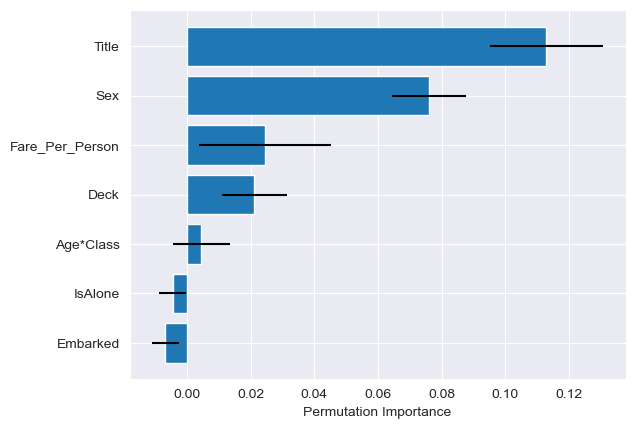

In [49]:
importance = results.importances_mean
std = results.importances_std

features = X_train.columns
sorted_idx = importance.argsort()

plt.barh(range(len(sorted_idx)), importance[sorted_idx], xerr=std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

#### ElasticNet using L1 and L2 regularization gives insight onto Feature Importance

In [50]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    elastic_net = make_pipeline(StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42))

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(elastic_net, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

    return np.mean(scores)

In [51]:

study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_trial.params
elastic_net = make_pipeline(StandardScaler(), ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'], random_state=42))
elastic_net.fit(X_train, y_train)

[I 2024-03-29 23:26:13,930] A new study created in memory with name: no-name-50ad0834-9319-4124-be53-0e43c402c2d7
[I 2024-03-29 23:26:14,011] Trial 0 finished with value: -0.2498932457225458 and parameters: {'alpha': 2.9950798453403698, 'l1_ratio': 0.5129122777700322}. Best is trial 0 with value: -0.2498932457225458.
[I 2024-03-29 23:26:14,097] Trial 1 finished with value: -0.17412242199219485 and parameters: {'alpha': 0.014217834036705635, 'l1_ratio': 0.5097505378753526}. Best is trial 1 with value: -0.17412242199219485.
[I 2024-03-29 23:26:14,119] Trial 2 finished with value: -0.2498932457225458 and parameters: {'alpha': 0.6247157651340576, 'l1_ratio': 0.6382514595500853}. Best is trial 1 with value: -0.17412242199219485.
[I 2024-03-29 23:26:14,141] Trial 3 finished with value: -0.17355924580295395 and parameters: {'alpha': 0.0046095792503418895, 'l1_ratio': 0.07190280876613353}. Best is trial 3 with value: -0.17355924580295395.
[I 2024-03-29 23:26:14,161] Trial 4 finished with value

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.024229520123493144,
                            l1_ratio=0.0013723804851094347, random_state=42))])

In [52]:
feature_importance = elastic_net.named_steps['elasticnet'].coef_

feature_names = X_train.columns
importance_series = pd.Series(feature_importance, index=feature_names)
sorted_features = importance_series.abs().sort_values(ascending=False)
print(sorted_features)

Sex                0.198582
Fare_Per_Person    0.090753
IsAlone            0.073568
Deck               0.066524
Title              0.059244
Embarked           0.052797
Age*Class          0.027903
dtype: float64


## RandomForestClassifier

In [53]:
from sklearn.ensemble import RandomForestClassifier


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**param, random_state=random_id)
    
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()

In [54]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print(f"Best trial accuracy: {study.best_trial.value}")

[I 2024-03-29 23:26:16,638] A new study created in memory with name: no-name-abe7417d-ff6f-418f-b5bf-37728cca2c1f
[I 2024-03-29 23:26:18,661] Trial 0 finished with value: 0.8287292817679557 and parameters: {'n_estimators': 274, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8287292817679557.
[I 2024-03-29 23:26:19,591] Trial 1 finished with value: 0.8209944751381215 and parameters: {'n_estimators': 177, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8287292817679557.
[I 2024-03-29 23:26:22,468] Trial 2 finished with value: 0.8165745856353592 and parameters: {'n_estimators': 742, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8287292817679557.
[I 2024-03-29 23:26:24,643] Trial 3 finished with value: 0.81546961325966

Number of finished trials: 30
Best trial: {'n_estimators': 396, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}
Best trial accuracy: 0.8353591160220996


In [55]:
randomForest_classifier = RandomForestClassifier()
randomForest_classifier.set_params(**study.best_trial.params)
randomForest_classifier.fit(X_train, y_train)
y_pred = randomForest_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


### Compare accuracy to supposed real data

In [56]:
submission_test = randomForest_classifier.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId', suffixes=('_df1', '_df2'))
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")


Accuracy Score: 0.7587939698492462


In [57]:
#submission_test.to_csv("submission_test_randomForest_3.csv")

In [58]:
to_test.columns

Index(['Embarked', 'Deck', 'Title', 'Sex', 'IsAlone', 'Age*Class',
       'Fare_Per_Person'],
      dtype='object')

### Try out ensemble of different models

In [59]:
stacking_clf = StackingClassifier(
    estimators=[('rf', randomForest_classifier), ('xgb', xgb_classifier)],
    final_estimator=LogisticRegression(),
    stack_method='auto',
    cv=10
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=14,
                                                       min_samples_split=6,
                                                       n_estimators=396)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5556925659207662,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=Non...
                                              interaction_constraints=None,
                                              learning_rate=0.01964678370543278,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=512, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [60]:
accuracy = stacking_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.770949720670391


In [61]:
submission_test = stacking_clf.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId')
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.7386934673366834


In [62]:
#submission_test.to_csv("submission_test_ensemble.csv")

In [63]:
X_train.columns.to_list()

['Embarked', 'Deck', 'Title', 'Sex', 'IsAlone', 'Age*Class', 'Fare_Per_Person']

In [64]:
def objective(trial):
    # SVM hyperparameters to tune
    param = {
        'C': trial.suggest_float('C', 0.1, 10.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),  # Consider excluding 'poly' for speed
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),  # 'auto' uses 1 / n_features
        # Commenting out degree and coef0 to speed up the process
        # 'degree': trial.suggest_int('degree', 1, 3),  # Higher degrees can be very slow
        # 'coef0': trial.suggest_float('coef0', 0.0, 1.0),
    }

    model = SVC(**param, random_state=random_id)
    
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()
 
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_trial.params
svm_classifier = SVC(**best_params, random_state=random_id)
svm_classifier.fit(X_train, y_train)

[I 2024-03-29 23:27:52,697] A new study created in memory with name: no-name-1b7da870-64c4-49b8-9270-537f7e3ad92a
[I 2024-03-29 23:27:55,601] Trial 0 finished with value: 0.743646408839779 and parameters: {'C': 0.9182189016422406, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.743646408839779.
[I 2024-03-29 23:27:55,703] Trial 1 finished with value: 0.6519337016574586 and parameters: {'C': 7.004501395165114, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.743646408839779.
[I 2024-03-29 23:28:18,249] Trial 2 finished with value: 0.7447513812154696 and parameters: {'C': 9.320155392330783, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.7447513812154696.
[I 2024-03-29 23:28:18,426] Trial 3 finished with value: 0.7193370165745857 and parameters: {'C': 7.233147105140089, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.7447513812154696.
[I 2024-03-29 23:28:37,999] Trial 4 finished with value: 0.7414364640883977 and

SVC(C=8.582231826076045, gamma='auto', kernel='linear', random_state=17)

In [65]:

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_classifier), 
        ('svm', svm_classifier)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Fit the StackingClassifier
stacking_clf.fit(X_train, y_train)

# Evaluate the model using appropriate metrics like F1 score or ROC AUC
from sklearn.metrics import f1_score, roc_auc_score

# Assuming you have a validation set to evaluate your model
y_pred = stacking_clf.predict(X_test)
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]  # Assuming binary classification: [0, 1]

# Calculate F1 score and ROC AUC
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [66]:
f1

0.7074829931972789

In [67]:
roc_auc

0.8046652881881623

In [68]:
accuracy_score(y_test, y_pred)

0.7597765363128491

In [69]:
submission_test = stacking_clf.predict(to_test)
submission_test = pd.Series(submission_test, to_test.index, name='Survived')
actual_data = pd.read_csv("test_results.csv",index_col="PassengerId")
merged_df = pd.merge(actual_data, submission_test, on='PassengerId')
# Step 3: Calculate accuracy score
accuracy = accuracy_score(merged_df['survived'], merged_df['Survived'])

print(f"Accuracy Score: {accuracy}")


Accuracy Score: 0.7386934673366834
